In [2]:
%pylab inline
import h5py
h5py.enable_ipython_completer()


#selecting the file
generic_name = '/cosma7/data/Eagle/ScienceRuns/Planck1/L0100N1504/PE/REFERENCE/data/'
specific_name = ['groups_012_z003p017/eagle_subfind_tab_012_z003p017.']

#these are generalised in case specific_name contains more than one file
FirstSubhaloID = [[] for i in range(len(specific_name))]  #main halos
Pos = [[] for i in range(len(specific_name))]  #positions
SFR = [[] for i in range(len(specific_name))]  #SFR
M200 = [[] for i in range(len(specific_name))]  #Mass inside the radius where the mean density is higher than 200 the critical density of the Universe
MassType = [[] for i in range(len(specific_name))]   #Mass
redshift = []  #Redshift
R200 = [[] for i in range(len(specific_name))] #Radius inside of which the mean density os higher than 200 the critical density

#open a file just to make the program work
myfile1 = generic_name+specific_name[0]+'0.hdf5'
myfile = h5py.File(myfile1, 'r')

#read data
for i in range(len(specific_name)):
    filename = generic_name + specific_name[i] + '0.hdf5'
    myfile = h5py.File(filename, 'r')
    NumFilesPerSnapshot = myfile['Header'].attrs['NumFilesPerSnapshot']
    print(NumFilesPerSnapshot)

    for j in range(NumFilesPerSnapshot):
        
        filename = generic_name + specific_name[i] + '%d.hdf5' %j
        myfile = h5py.File(filename, 'r')
        
        FirstSubhaloID[i].extend(myfile['FOF/FirstSubhaloID'][()])
        Pos[i].append(myfile['Subhalo/CentreOfMass'][()])
        SFR[i].extend(myfile['Subhalo/StarFormationRate'][()])
        M200[i].extend(myfile['FOF/Group_M_Crit200'][()]* 1e10) 
        MassType[i].append(myfile['Subhalo/MassType'][()] * 1e10)
        R200[i].extend(myfile['FOF/Group_R_Crit200'][()]* 3.085678e+24)
        if j==0:
            redshift.append(myfile['Header'].attrs['Redshift'])
        
        myfile.close()

Populating the interactive namespace from numpy and matplotlib
1536


In [3]:
#shaping the arrays
for i in range(len(specific_name)):
    Pos[i] = np.vstack(Pos[i])
    MassType[i] = np.vstack(MassType[i])
    print(Pos[i].shape)
    print(MassType[i].shape)

    SFR[i] = np.asarray(SFR[i])
    M200[i] = np.asarray(M200[i])
    R200[i] = np.asarray(R200[i])
    
print(np.shape(SFR), np.shape(M200))

(3069221, 3)
(3069221, 6)
(1, 3069221) (1, 2595893)


In [4]:
#Lya luminosity as in Mckenzie at al
#Lya = 10^42*SFR

L_lya = [[] for i in range(len(specific_name))]

for i in range(len(specific_name)):
    L_lya[i] = 10**42*SFR[i]

In [5]:
#Lya luminosity function

minimo = np.min(L_lya[0][L_lya[0]!=0]) #minimum Lya_lum 
massimo = np.max(L_lya[0]) #maximum Lya_lum

print(massimo == np.max(L_lya[0]))
nbins = 25   #number of log bins for the lum function
lyabins = np.logspace(np.log10(minimo), np.log10(massimo), nbins)   
lyabins_average = np.array((np.log10(lyabins[1:]) - np.log10(lyabins[:-1]))/2 + np.log10(lyabins[:-1]))
lyabins_average = 10**lyabins_average
#print((lyabins_average))

#this array has the dimension of the number of bins and inside each element I store the galaxies ID belonging to that bin
counts = [[] for i in range(len(lyabins_average))]  

#this array on the other hand has the dimension of the total IDs and for each entry we got the bin number to which it belongs
belonging_bin = [] 

for i in range(len(L_lya[0])):
    for j in range(len(lyabins)):
        if L_lya[0][i] >= lyabins[-1]:  #just to be sure
            counts[-1].append(i)
            print('last one')
            belonging_bin.append(len(lyabins_average)-1)
            break
        if L_lya[0][i] < lyabins[0]:
            belonging_bin.append('None')
            break
        if L_lya[0][i]<lyabins[j]:
            counts[j-1].append(i)
            #print(L_lya[1][i], lyabins[j],j)
            belonging_bin.append(j-1)
            break
        
#counting the elements inside each bin            
counts_sum = []

for i in range(len(counts)):
    counts_sum.append(len(counts[i]))
    
counts_sum = np.array(counts_sum)

True


-1.779276391059689


Text(0, 0.5, 'log $\\phi$ [Mpc$^{-3}$ dex$^{-1}$]')

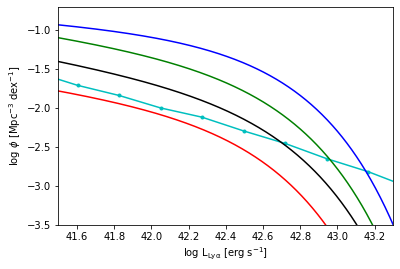

In [6]:
#plt.figure(figsize=(5,5))

#luminosity function per unit volume per unit dlogL
lya_lum_fun = counts_sum/10**6/(np.log10(lyabins[1:])-np.log10(lyabins[:-1]))

plt.plot(np.log10(lyabins_average), np.log10(lya_lum_fun), '.c-')
plt.xlabel(r'Ly$\alpha$ luminosity [erg s$^{-1}$]')
plt.ylabel(r'$\phi$ [Mpc$^{-3}$ (dlog$_{10}$L)$^{-1}$]')

plt.xlim(41.5, 43.3)
plt.ylim(-3.5, -0.7)

#these are the results from the same analysis done by Mackenzie
mackenzie =  np.loadtxt('Mackenzie.txt')


#luminosity function defined by Drake et al 2017
def lum_fun(L, phi_star, alpha, L_star):
    return np.log(10)*phi_star*10**((L-L_star)*(alpha +1))*np.exp(-10**(L-L_star))

#from Drake 2017
alpha = -2.03
L_star = (42.72)
phi_star = 10**(-3.1)

#from MAGG (the last one is the one I should use, the others are valid for selected samples)
alpha = [-1.164,-1.350,-1.418,-1.339]
L_star = [42.573, 42.558, 42.575, 42.466]
phi_star = [10**(-1.429), 10**(-1.788), 10**(-2.175), 10**(-2.422)]
color=['blue', 'green', 'black', 'red']

err_par = [10**(0.121), 0.158, 0.08] #err_phi, err_alpha, err_logL_star

x_axis = np.logspace(40.3, 43.5, 1000)
for i in range(len(alpha)):
    lum_f = lum_fun(np.log10(x_axis), phi_star[i], alpha[i], L_star[i])
    if i==(len(alpha)-1):
        print(np.log10(lum_fun(41.5, phi_star[i], alpha[i], L_star[i])))
    plt.plot(np.log10(x_axis), np.log10(lum_f), color=color[i])
    

plt.xlabel(r'log L$_{\mathrm{Ly\alpha}}$ [erg s$^{-1}$]')
plt.ylabel(r'log $\phi$ [Mpc$^{-3}$ dex$^{-1}$]')

In [7]:
#probability of extracting a galaxy inside a given L_lya bin evaluated as the ratio in correspondence of 
#the average point of the bin between MAGG Schechter function and my function

perc = []

for i in range(len(lyabins_average)):
    perc.append(lum_fun(np.log10(lyabins_average[i]), phi_star[-1], alpha[-1], L_star[-1])/lya_lum_fun[i])

print(perc)
#creating a boolean array of the same dimension of the galaxy elements extracting true or false based on the computed prob
hitormiss = []
np.random.seed(10)
for i in range(len(belonging_bin)):
    
    if belonging_bin[i] == 'None':
            hitormiss.append('False')  #I add false for all the galaxy for which SFR = 0, it doesn't really matter 
    for j in range(len(lyabins_average)):
        if belonging_bin[i] == j:
            if perc[j] >=1 : 
                hitormiss.append('True') #No correction to the LF if perc>=1
            else:
                hitormiss.append(np.random.choice(['True', 'False'], p=[perc[j], 1-perc[j]]))

hitormiss = np.array(hitormiss)
L_lya_corr = L_lya[0][hitormiss == 'True']  #taking only the extracted true values

#doing again the Lya luminosity function with the extracted True elements
counts_corr = [[] for i in range(len(lyabins_average))]
pos_lya_sel = [[] for i in range(len(lyabins_average))]

for i in range(len(L_lya_corr)):
    for j in range(len(lyabins)):
        if L_lya_corr[i] == lyabins[-1]:
            counts_corr[-1].append(i)
            print('last one')
            break
        if L_lya_corr[i] < lyabins[0]:
            break
        if L_lya_corr[i] <lyabins[j]:
            counts_corr[j-1].append(i)
            break


[1.5351237260056945, 1.5020782476285823, 1.2996759942439653, 1.0612803031806524, 0.8448141456045252, 0.6227491983611946, 0.48850055599985703, 0.4040752858524606, 0.3825731562598037, 0.40040681445501664, 0.5099997625771864, 0.6474808363328388, 0.7581524360609788, 0.7844320371572251, 0.817817319893591, 0.6992495567928622, 0.5736993010465052, 0.3400693175947846, 0.1345051657821998, 0.022221839392191793, 0.0010358963072145814, 4.96569491822425e-06, 1.0097589352097883e-09, 9.337937708800795e-16]


/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


[-1.04522359 -1.1115412  -1.12450847 -1.1124223  -1.16196502 -1.24071716
 -1.31205976 -1.39596754 -1.46753789 -1.55508784 -1.63877569 -1.72308448
 -1.83095297 -1.9451732  -2.07719909 -2.27619092 -2.52598675 -2.93216789
 -3.53589504 -4.50371035 -5.34880839        -inf        -inf        -inf]


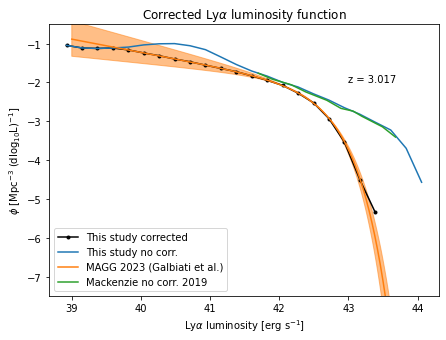

In [8]:
#and corrected luminosity function again
counts_corr_sum = []

for i in range(len(counts_corr)):
    counts_corr_sum.append(len(counts_corr[i]))
    
counts_corr_sum = np.array(counts_corr_sum)

plt.figure(figsize=(7,5))

x_logsp = np.logspace(39, 44, 500)
magg = lum_fun(np.log10(x_logsp), phi_star[-1], alpha[-1], L_star[-1])
magg_1s_min = lum_fun(np.log10(x_logsp), phi_star[-1]/err_par[0], alpha[-1]-err_par[1], L_star[-1]+err_par[2])
magg_1s_max = lum_fun(np.log10(x_logsp), phi_star[-1]*err_par[0], alpha[-1]+err_par[1], L_star[-1]-err_par[2])

lya_lum_fun_corr = counts_corr_sum/10**6/(np.log10(lyabins[1:])-np.log10(lyabins[:-1]))
plt.plot(np.log10(lyabins_average), np.log10(lya_lum_fun_corr), '.k-', label='This study corrected')

plt.xlabel(r'Ly$\alpha$ luminosity [erg s$^{-1}$]')
plt.ylabel(r'$\phi$ [Mpc$^{-3}$ (dlog$_{10}$L)$^{-1}$]')
plt.text(43, -2, 'z = %.3f' %redshift[0] )
plt.title(r'Corrected Ly$\alpha$ luminosity function')
#plt.xlim(41.5, 43.3)
plt.ylim(-7.5, -0.5)

plt.plot(np.log10(lyabins_average), np.log10(lya_lum_fun), label='This study no corr.')
plt.plot(np.log10(x_logsp), np.log10(magg), label='MAGG 2023 (Galbiati et al.)')
plt.plot(np.log10(mackenzie[:,0]), np.log10(mackenzie[:,1]), label='Mackenzie no corr. 2019')
plt.fill_between(np.log10(x_logsp), np.log10(magg_1s_min), np.log10(magg_1s_max), color='tab:orange', alpha=0.5)
print(np.log10(lya_lum_fun_corr))
plt.legend()
plt.savefig('corrected_luminosity_function')# bbox_inches='tight')

3069221 3069221 152496 152496
Total Number of lines: 152496


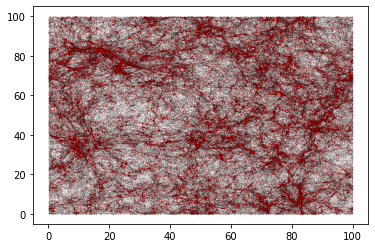

In [9]:
#positions in units of Mpc
Pos_Mpc = np.copy(Pos)
Pos_Mpc[0] = Pos_Mpc[0][:,:]/0.6777000
plt.plot(Pos_Mpc[0][:,0], Pos_Mpc[0][:,1], '.k', markersize=0.01)

#considering only the positions of objects considered in the Lya lum function
Pos_Mpc_corr = Pos_Mpc[0][hitormiss=='True']
print(len(Pos[0]), len(Pos_Mpc[0]), len(L_lya_corr), len(Pos_Mpc_corr))

#Position, case-Blyalum, SFR, stellar mass
np.savetxt('Pos_raw_andLlya.txt', np.array([Pos_Mpc[0][:,0], Pos_Mpc[0][:,1], Pos_Mpc[0][:,2], L_lya[0], SFR[0], MassType[0][:,4], MassType[0][:,1]]).T)

np.savetxt('Pos_lumfun.txt', np.array([Pos_Mpc_corr[:,0], Pos_Mpc_corr[:,1], Pos_Mpc_corr[:,2], L_lya_corr]).T )
with open(r"Pos_lumfun.txt", 'r') as fp:
    lines = len(fp.readlines())
    print('Total Number of lines:', lines)

plt.plot(Pos_Mpc_corr[:,0], Pos_Mpc_corr[:,1], 'or', markersize=0.02)

In [10]:
print(Pos_Mpc_corr)

[[24.511623 77.038826 60.138126]
 [24.26412  77.4371   61.27078 ]
 [24.189785 77.42553  61.426235]
 ...
 [51.957165 46.54338  52.50293 ]
 [22.245451 72.83956  66.20816 ]
 [ 8.02158  30.402145 44.85814 ]]


In [11]:
print(np.array([Pos_Mpc_corr[:,0], Pos_Mpc_corr[:,1], Pos_Mpc_corr[:,2], L_lya_corr]).T)

[[24.51162338256836 77.03882598876953 60.138126373291016
  3.5563814640045165e+42]
 [24.26412010192871 77.43710327148438 61.27077865600586
  6.405633091926575e+41]
 [24.18978500366211 77.42552947998047 61.42623519897461
  3.20304274559021e+42]
 ...
 [51.9571647644043 46.54338073730469 52.5029296875 9.559025056660175e+38]
 [22.245450973510742 72.83956146240234 66.20816040039062
  1.0043163783848286e+39]
 [8.02157974243164 30.402145385742188 44.85813903808594
  8.014453342184425e+38]]


In [12]:
print(len(Pos[0]), len(MassType[0]))

3069221 3069221
